# LLM - Detect AI Generated Text
# (CNN) Convolution Neural Network

## Import

In [1]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve ,precision_recall_curve,auc,confusion_matrix,ConfusionMatrixDisplay
import keras


2024-01-09 19:16:10.629239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 19:16:10.629267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 19:16:10.659475: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 19:16:10.723491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 19:16:11.781434: W tensorflow/compiler/tf2

In [3]:
pre_processed_data=pd.read_csv("../data/CNN/pre_process_train.csv")
pre_processed_data

/tmp/ipykernel_14614/3693482564.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pre_processed_data=pd.read_csv("../data/NN/pre_process_train.csv")


,id,prompt_id,generated,0,1,2,3,4,5,6,...,96,97,98,99,normalized_norm,token_num,sent_num,punct_sym,apostrof_sym,unk_num
0,0059830c,0,0,0.031006,0.005868,0.000175,0.040530,-0.008923,-0.024766,-0.075533,...,-0.023679,0.007964,-0.097951,-0.013403,0.386702,0.003912,0.004492,0.005521,0.000000,0
1,005db917,0,0,-0.009186,-0.049469,-0.024262,-0.027737,0.044426,-0.023337,-0.037656,...,-0.038399,0.020613,0.022102,-0.008245,0.370435,0.003912,0.004866,0.004616,0.004868,0
2,008f63e3,0,0,-0.127259,-0.009322,0.094947,0.043751,0.081350,-0.062914,-0.065543,...,0.000657,-0.040317,-0.002923,-0.069843,0.396177,0.003912,0.008983,0.006969,0.002434,0
3,00940276,0,0,-0.083473,-0.041759,-0.095021,0.010098,0.053566,-0.077048,-0.098504,...,-0.020585,-0.030012,0.073441,-0.113554,0.405722,0.003912,0.006550,0.007240,0.000000,0
4,00c39458,0,0,-0.100145,-0.040200,0.055441,0.077485,-0.011119,-0.083053,-0.108298,...,0.003750,0.039632,0.014942,-0.046859,0.451901,0.003912,0.008983,0.007602,0.002434,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65349,65525,1,1,-0.001667,-0.005254,0.003478,-0.046774,0.119164,0.074849,0.061789,...,0.053973,0.040873,0.061876,-0.005299,0.270148,0.003912,0.003369,0.003258,0.000000,0
65350,65526,1,1,0.012272,-0.009188,-0.117230,0.009980,0.058147,0.089310,0.026512,...,0.089401,0.052531,0.021248,-0.058458,0.351528,0.003912,0.004305,0.003711,0.000000,0
65351,65527,1,1,-0.003841,0.184542,-0.018318,-0.000038,0.003925,0.038930,-0.023688,...,-0.003992,-0.023140,-0.023155,0.065200,0.295845,0.003912,0.003743,0.003530,0.000000,0
65352,65528,1,1,0.089967,0.021360,-0.036671,-0.036774,0.053695,0.083478,0.015443,...,0.026922,0.049378,0.014431,-0.028427,0.311500,0.003912,0.003369,0.003168,0.000000,0


## Random Downsampling

In [4]:
def downsampling(X_train,y_train,rand_state,ratio):
    # Concatenate X_train and y_train for ease of downsampling
    train_data = pd.concat([X_train, y_train], axis=1)

    # Identify the class with the majority of instances
    majority_class = train_data[y_train.name].value_counts().idxmax()

    # Separate instances of each class
    majority_class_data = train_data[train_data[y_train.name] == majority_class]
    minority_class_data = train_data[train_data[y_train.name] != majority_class]


    currRatio = len(majority_class_data) / len(minority_class_data)
    if(currRatio<=ratio):
        raise ValueError(f"El ratio de entrada debe ser menor al ratio actual.r={currRatio}")


    # Downsample the majority class to match the number of instances in the minority class
    downsampled_majority_class_data = resample(
        majority_class_data,
        replace=False,
        n_samples=math.floor(ratio*len(minority_class_data)),
        random_state=rand_state
    )

    # Combine the downsampled majority class with the minority class
    downsampled_train_data = pd.concat([downsampled_majority_class_data, minority_class_data])

    # Shuffle the data to avoid any order-based patterns
    downsampled_train_data = downsampled_train_data.sample(frac=1, random_state=rand_state)

    # Separate X_train and y_train after downsampling
    X_train_downsampled = downsampled_train_data.drop(columns=[y_train.name])
    y_train_downsampled = downsampled_train_data[y_train.name]

    return X_train_downsampled, y_train_downsampled

## ROC AUC curve

In [5]:
def ROCcurves(model,x_val,y_val):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    y_pred = model.predict(x_val).ravel()
    fpr, tpr , _ = roc_curve(y_val,  y_pred)
    auc_ss = auc(fpr,tpr)
    precision, recall, _ = precision_recall_curve(y_val,  y_pred)
    auc_pr = auc(recall, precision)

    # Primer subgráfico
    axs[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='AUC = 0.50')
    axs[0].plot(fpr,tpr, label='ROC curve', color='blue')
    axs[0].set_title(f'ROC curve = {round(auc_ss,3)}')
    axs[0].set_xlabel('FalsePositiveRate')
    axs[0].set_ylabel('TruePositiveRate')
    axs[0].legend()
    # Segundo subgráfico
    axs[1].plot([0, 1], [0,0], color='gray', lw=1, linestyle='--', label='AUC = 0.0')
    axs[1].plot(recall, precision, label='ROC-RP curve', color='orange')
    axs[1].set_title(f'ROC-RP curve = {round(auc_pr,3)}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()
    plt.show()



## Arquitecture

In [6]:
input = keras.Input(shape=(None,pre_processed_data.shape[1]-2),batch_size=500)
x = keras.layers.Reshape(target_shape=(pre_processed_data.shape[1]-2,1))(input)
x = keras.layers.Convolution1D(100,kernel_size=10,padding="same",strides=1,activation="relu")(x)
x = keras.layers.Dense(300,activation="relu")(x)
output = keras.layers.Dense(1,activation="sigmoid")(x)

model = keras.Model(input,output)

model.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.AUC()])

## Training

In [7]:
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = pre_processed_data.drop(["id","generated"],axis=1)
Y = pre_processed_data["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1.3)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")

    model.fit(X_train_dwns,
                y_train_dwns,
                validation_data=(X_val,y_val),
                batch_size=1000,
                epochs=13)

DOWNSAMPLED:(24633:32022)
Epoch 1/13


2024-01-09 19:16:25.129371: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48496680 exceeds 10% of free system memory.


57/57 [==============================] - 2s 17ms/step - loss: 0.6203 - auc: 0.6933 - val_loss: 0.5027 - val_auc: 0.8480
Epoch 2/13
57/57 [==============================] - 1s 13ms/step - loss: 0.4563 - auc: 0.8619 - val_loss: 0.4157 - val_auc: 0.8862
Epoch 3/13
57/57 [==============================] - 1s 14ms/step - loss: 0.4116 - auc: 0.8900 - val_loss: 0.4249 - val_auc: 0.8990
Epoch 4/13
57/57 [==============================] - 1s 13ms/step - loss: 0.3967 - auc: 0.8983 - val_loss: 0.4038 - val_auc: 0.9086
Epoch 5/13
57/57 [==============================] - 1s 13ms/step - loss: 0.3744 - auc: 0.9101 - val_loss: 0.3557 - val_auc: 0.9212
Epoch 6/13
57/57 [==============================] - 1s 14ms/step - loss: 0.3457 - auc: 0.9242 - val_loss: 0.3322 - val_auc: 0.9312
Epoch 7/13
57/57 [==============================] - 1s 13ms/step - loss: 0.3350 - auc: 0.9288 - val_loss: 0.3373 - val_auc: 0.9359
Epoch 8/13
57/57 [==============================] - 1s 12ms/step - loss: 0.3084 - auc: 0.9402 

2024-01-09 19:16:35.854914: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48499248 exceeds 10% of free system memory.


57/57 [==============================] - 1s 12ms/step - loss: 0.2571 - auc: 0.9586 - val_loss: 0.2445 - val_auc: 0.9626
Epoch 2/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2592 - auc: 0.9580 - val_loss: 0.2749 - val_auc: 0.9620
Epoch 3/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2504 - auc: 0.9608 - val_loss: 0.2508 - val_auc: 0.9625
Epoch 4/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2517 - auc: 0.9604 - val_loss: 0.2961 - val_auc: 0.9596
Epoch 5/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2411 - auc: 0.9635 - val_loss: 0.2430 - val_auc: 0.9628
Epoch 6/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2325 - auc: 0.9661 - val_loss: 0.2615 - val_auc: 0.9617
Epoch 7/13
57/57 [==============================] - 1s 11ms/step - loss: 0.2263 - auc: 0.9679 - val_loss: 0.2479 - val_auc: 0.9618
Epoch 8/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2193 - auc: 0.9698 

2024-01-09 19:16:44.792094: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48499248 exceeds 10% of free system memory.


57/57 [==============================] - 1s 13ms/step - loss: 0.2147 - auc: 0.9711 - val_loss: 0.2244 - val_auc: 0.9708
Epoch 2/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2153 - auc: 0.9707 - val_loss: 0.2617 - val_auc: 0.9748
Epoch 3/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2069 - auc: 0.9730 - val_loss: 0.1985 - val_auc: 0.9752
Epoch 4/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2050 - auc: 0.9735 - val_loss: 0.2000 - val_auc: 0.9752
Epoch 5/13
57/57 [==============================] - 1s 12ms/step - loss: 0.2027 - auc: 0.9741 - val_loss: 0.2065 - val_auc: 0.9756
Epoch 6/13
57/57 [==============================] - 1s 11ms/step - loss: 0.1985 - auc: 0.9751 - val_loss: 0.2085 - val_auc: 0.9758
Epoch 7/13
57/57 [==============================] - 1s 12ms/step - loss: 0.1979 - auc: 0.9752 - val_loss: 0.2075 - val_auc: 0.9736
Epoch 8/13
57/57 [==============================] - 1s 12ms/step - loss: 0.1947 - auc: 0.9760 

2024-01-09 19:16:54.167952: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48499248 exceeds 10% of free system memory.


57/57 [==============================] - 1s 13ms/step - loss: 0.1913 - auc: 0.9767 - val_loss: 0.1795 - val_auc: 0.9798
Epoch 2/13
57/57 [==============================] - 1s 12ms/step - loss: 0.1877 - auc: 0.9777 - val_loss: 0.1864 - val_auc: 0.9796
Epoch 3/13
57/57 [==============================] - 1s 12ms/step - loss: 0.1830 - auc: 0.9788 - val_loss: 0.1835 - val_auc: 0.9799
Epoch 4/13
57/57 [==============================] - 1s 13ms/step - loss: 0.1848 - auc: 0.9784 - val_loss: 0.2015 - val_auc: 0.9792
Epoch 5/13
57/57 [==============================] - 1s 13ms/step - loss: 0.1887 - auc: 0.9775 - val_loss: 0.1801 - val_auc: 0.9801
Epoch 6/13
57/57 [==============================] - 1s 13ms/step - loss: 0.1806 - auc: 0.9794 - val_loss: 0.1971 - val_auc: 0.9790
Epoch 7/13
57/57 [==============================] - 1s 12ms/step - loss: 0.1760 - auc: 0.9803 - val_loss: 0.1775 - val_auc: 0.9801
Epoch 8/13
57/57 [==============================] - 1s 11ms/step - loss: 0.1767 - auc: 0.9802 

2024-01-09 19:17:03.643564: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48499248 exceeds 10% of free system memory.


57/57 [==============================] - 1s 13ms/step - loss: 0.1674 - auc: 0.9822 - val_loss: 0.1721 - val_auc: 0.9831
Epoch 2/13
57/57 [==============================] - 1s 12ms/step - loss: 0.1664 - auc: 0.9824 - val_loss: 0.1700 - val_auc: 0.9824
Epoch 3/13
57/57 [==============================] - 1s 12ms/step - loss: 0.1652 - auc: 0.9827 - val_loss: 0.1634 - val_auc: 0.9829
Epoch 4/13
57/57 [==============================] - 1s 14ms/step - loss: 0.1637 - auc: 0.9829 - val_loss: 0.1645 - val_auc: 0.9830
Epoch 5/13
57/57 [==============================] - 1s 13ms/step - loss: 0.1632 - auc: 0.9831 - val_loss: 0.1662 - val_auc: 0.9827
Epoch 6/13
57/57 [==============================] - 1s 13ms/step - loss: 0.1602 - auc: 0.9837 - val_loss: 0.1678 - val_auc: 0.9828
Epoch 7/13
57/57 [==============================] - 1s 14ms/step - loss: 0.1586 - auc: 0.9841 - val_loss: 0.1724 - val_auc: 0.9819
Epoch 8/13
57/57 [==============================] - 1s 12ms/step - loss: 0.1547 - auc: 0.9847 

2043/2043 [==============================] - 3s 1ms/step


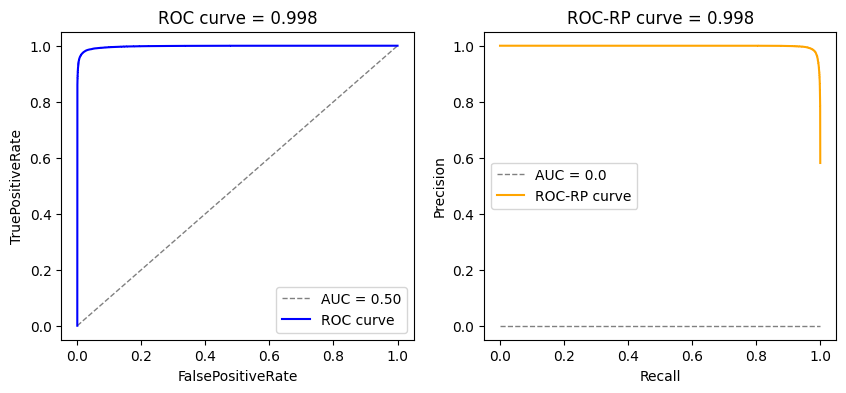

In [ ]:
ROCcurves(model,X,Y)

2043/2043 [==============================] - 3s 2ms/step


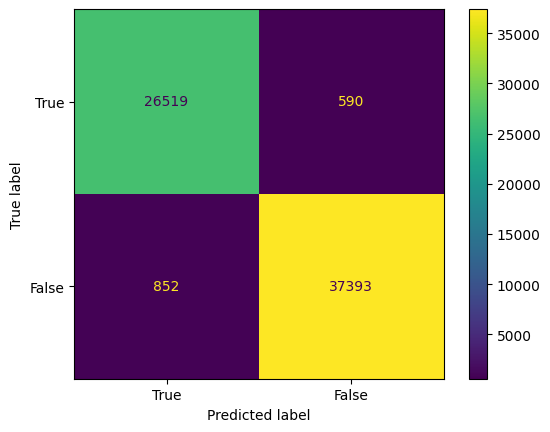

In [ ]:
pred = list(map(lambda pred : 1 if pred > 0.5 else 0,model.predict(x=X)))
display = ConfusionMatrixDisplay(confusion_matrix(pred,Y),display_labels=["True","False"])
display.plot()

In [ ]:
model.predict(x=pd.DataFrame(X.iloc[1385]).transpose())

1/1 [==============================] - 0s 13ms/step


array([[1.]], dtype=float32)

## Save model weights

In [ ]:

model.save("../data/CNN/weight/ConvolutionNetwork.h5")

/home/mrtc101/Desktop/ciencias de la computacion/Cursado/4.2Inteligencia Artificial 2/Final/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
